# CRAFT fine-tuning for Twitter Conversation Forecasting

This notebook walks through fine-tuning the CRAFT model proposed by Chang et al on our Twitter Conversation data. We are using this model as the baseline for our task of forecasting personal attacks in Twitter conversations.

Credit for this base code goes to the authors of "Trouble on the Horizon" paper. See notebook below for original fine-tuning process.

https://colab.research.google.com/drive/1SH4iMEHdoH4IovN-b9QOSK4kG4DhAwmb#scrollTo=A-MyiLgJnkle




In [ ]:
# start by installing ConvoKit on the colab VM
!pip install -q convokit

In [ ]:
# import necessary libraries, including convokit
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import requests
import os
import sys
import random
import unicodedata
import itertools
from urllib.request import urlretrieve
from convokit import download, Corpus
import io
import re
%matplotlib inline

# Loading Our Convo Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
corpus_train_path = "/content/drive/My Drive/data_twitter/train_data_baseline_2021-04-04_v1.csv"
corpus_val_path = "/content/drive/My Drive/data_twitter/val_data_baseline_2021-04-04_v1.csv"
corpus_test_path = "/content/drive/My Drive/data_twitter/test_data_baseline_2021-04-04_v1.csv"

In [ ]:
corpus_train = pd.read_csv(corpus_train_path)
corpus_val = pd.read_csv(corpus_val_path)
corpus_test = pd.read_csv(corpus_test_path)

In [ ]:
# define globals and constants

MAX_LENGTH = 130  # Maximum sentence length (number of tokens) to consider

# configure model
hidden_size = 500
encoder_n_layers = 2
context_encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 1e-5
decoder_learning_ratio = 5.0
print_every = 10
train_epochs = 5

# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token
UNK_token = 3  # Unknown word token

# model download paths
WORD2INDEX_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/word2index.json"
INDEX2WORD_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/index2word.json"
MODEL_URL = "http://zissou.infosci.cornell.edu/convokit/models/craft_wikiconv/craft_pretrained.tar"

# confidence score threshold for declaring a positive prediction.
# this value was previously learned on the validation set.
FORECAST_THRESH = 0.570617

## Part 1: set up data conversion utilities 

We begin by setting up some helper functions and classes for converting conversational text data into a torch-friendly Tensor format. Note that these low-level routines are largely taken from the [PyTorch seq2seq chatbot tutorial](https://pytorch.org/tutorials/beginner/chatbot_tutorial.html).

In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    """A class for representing the vocabulary used by a CRAFT model"""

    def __init__(self, name, word2index=None, index2word=None):
        self.name = name
        self.trimmed = False if not word2index else True # if a precomputed vocab is specified assume the user wants to use it as-is
        self.word2index = word2index if word2index else {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = index2word if index2word else {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4 if not index2word else len(index2word)  # Count SOS, EOS, PAD, UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.num_words = 4 # Count default tokens

        for word in keep_words:
            self.addWord(word)

# Create a Voc object from precomputed data structures
def loadPrecomputedVoc(corpus_name, word2index_url, index2word_url):
    # load the word-to-index lookup map
    r = requests.get(word2index_url)
    word2index = r.json()
    # load the index-to-word lookup map
    r = requests.get(index2word_url)
    index2word = r.json()
    return Voc(corpus_name, word2index, index2word)

In [ ]:


# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    #Take out user handles and replace with nothing. Do we want to instead 
    #make this a user token?
    s = re.sub('@[^\s]+','',s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    formattedCorpus = []
    for index, value in corpus['Tweet'].items():
      formattedCorpus.append(normalizeString(value))
    voc = Voc(corpus_name)
    return voc, formattedCorpus


# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus_name, dataframe):
    voc, formattedCorpus = readVocs(dataframe, corpus_name)

    for tweet in formattedCorpus:
        voc.addSentence(tweet)
    print("Counted words:", voc.num_words)
    return voc


# # Load/Assemble voc and pairs
# save_dir = os.path.join("data", "save")
# voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# # Print some pairs to validate
# print("\npairs:")
# for pair in pairs[:10]:
#     print(pair)

In [ ]:
# Helper functions for preprocessing and tokenizing text

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Tokenize the string using NLTK
def tokenize(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(pattern=r'\w+|[^\w\s]')
    # simplify the problem space by considering only ASCII data
    cleaned_text = unicodeToAscii(text.lower())

    # if the resulting string is empty, nothing else to do
    if not cleaned_text.strip():
        return []
    
    return tokenizer.tokenize(cleaned_text)

def processDialog(voc, row, index):

    context_list = []
    
    full_context = [row['context_1'], row['context_2']]
    
    for context in full_context:

    
      #for tweet in context:
      context_tokens = tokenize(context)

      # replace out-of-vocabulary tokens
      for i in range(len(context_tokens)):
        if context_tokens[i] not in voc.word2index:
            context_tokens[i] = "UNK"
      context_list.append(context_tokens)

    #for reply:
    reply_tokens = tokenize(row['replies'])

    # replace out-of-vocabulary tokens
    for i in range(len(reply_tokens)):
      if reply_tokens[i] not in voc.word2index:
          reply_tokens[i] = "UNK"

    
    processed = {"tokens": context_list, "reply": reply_tokens, "is_attack": int(row['labels']), "id": index}
    
    return processed

def loadPairs(voc, corpus, split=None, last_only=False):
    pairs = []

    for index, row in corpus.iterrows():
      processed = processDialog(voc, row, index)

      context = processed['tokens']
      reply = processed['reply']
      label = processed['is_attack']
      comment_id = processed['id']

      pairs.append((context, reply, label, comment_id))

    return pairs



In [ ]:
# Helper functions for turning dialog and text sequences into tensors, and manipulating those tensors

def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence] + [EOS_token]

def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Takes a batch of dialogs (lists of lists of tokens) and converts it into a
# batch of utterances (lists of tokens) sorted by length, while keeping track of
# the information needed to reconstruct the original batch of dialogs
def dialogBatch2UtteranceBatch(dialog_batch):
    utt_tuples = [] # will store tuples of (utterance, original position in batch, original position in dialog)
    for batch_idx in range(len(dialog_batch)):
        dialog = dialog_batch[batch_idx]
        for dialog_idx in range(len(dialog)):
            utterance = dialog[dialog_idx]
            utt_tuples.append((utterance, batch_idx, dialog_idx))
    # sort the utterances in descending order of length, to remain consistent with pytorch padding requirements
    utt_tuples.sort(key=lambda x: len(x[0]), reverse=True)
    # return the utterances, original batch indices, and original dialog indices as separate lists
    utt_batch = [u[0] for u in utt_tuples]
    batch_indices = [u[1] for u in utt_tuples]
    dialog_indices = [u[2] for u in utt_tuples]
    return utt_batch, batch_indices, dialog_indices

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch, already_sorted=False):
    if not already_sorted:
        pair_batch.sort(key=lambda x: len(x[0]), reverse=True)
    input_batch, output_batch, label_batch, id_batch = [], [], [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
        label_batch.append(pair[2])
        id_batch.append(pair[3])
    dialog_lengths = torch.tensor([len(x) for x in input_batch])
    input_utterances, batch_indices, dialog_indices = dialogBatch2UtteranceBatch(input_batch)
    inp, utt_lengths = inputVar(input_utterances, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    label_batch = torch.FloatTensor(label_batch) if label_batch[0] is not None else None
    return inp, dialog_lengths, utt_lengths, batch_indices, dialog_indices, label_batch, id_batch, output, mask, max_target_len

def batchIterator(voc, source_data, batch_size, shuffle=True):
    cur_idx = 0
    if shuffle:
        random.shuffle(source_data)
    while True:
        if cur_idx >= len(source_data):
            cur_idx = 0
            if shuffle:
                random.shuffle(source_data)
        batch = source_data[cur_idx:(cur_idx+batch_size)]
        # the true batch size may be smaller than the given batch size if there is not enough data left
        true_batch_size = len(batch)
        # ensure that the dialogs in this batch are sorted by length, as expected by the padding module
        batch.sort(key=lambda x: len(x[0]), reverse=True)
        # for analysis purposes, get the source dialogs and labels associated with this batch
        batch_dialogs = [x[0] for x in batch]
        batch_labels = [x[2] for x in batch]
        # convert batch to tensors
        batch_tensors = batch2TrainData(voc, batch, already_sorted=True)
        yield (batch_tensors, batch_dialogs, batch_labels, true_batch_size) 
        cur_idx += batch_size

## Part 2: load the data


In [ ]:
# First, we need to build the vocabulary so that we know how to map tokens to tensor indicies.
# For the sake of replicating the paper results, we will load the pre-computed vocabulary objects used in the paper.
voc = loadPrecomputedVoc("wikiconv", WORD2INDEX_URL, INDEX2WORD_URL)

In [ ]:
train_pairs = loadPairs(voc, corpus_train, "train", last_only=True)
val_pairs = loadPairs(voc, corpus_val, "val", last_only=True)
test_pairs = loadPairs(voc, corpus_test, "test", last_only=True)

## Part 3: define the model

In [ ]:
class EncoderRNN(nn.Module):
    """This module represents the utterance encoder component of CRAFT, responsible for creating vector representations of utterances"""
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)


    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

class ContextEncoderRNN(nn.Module):
    """This module represents the context encoder component of CRAFT, responsible for creating an order-sensitive vector representation of conversation context"""
    def __init__(self, hidden_size, n_layers=1, dropout=0):
        super(ContextEncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        # only unidirectional GRU for context encoding
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=False)
        
    def forward(self, input_seq, input_lengths, hidden=None):
        # Pack padded batch of sequences for RNN module
        packed = torch.nn.utils.rnn.pack_padded_sequence(input_seq, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # return output and final hidden state
        return outputs, hidden

class SingleTargetClf(nn.Module):
    """This module represents the CRAFT classifier head, which takes the context encoding and uses it to make a forecast"""
    def __init__(self, hidden_size, dropout=0.1):
        super(SingleTargetClf, self).__init__()
        
        self.hidden_size = hidden_size
        
        # initialize classifier
        self.layer1 = nn.Linear(hidden_size, hidden_size)
        self.layer1_act = nn.LeakyReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size // 2)
        self.layer2_act = nn.LeakyReLU()
        self.clf = nn.Linear(hidden_size // 2, 1)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, encoder_outputs, encoder_input_lengths):
        # from stackoverflow (https://stackoverflow.com/questions/50856936/taking-the-last-state-from-bilstm-bigru-in-pytorch)
        # First we unsqueeze seqlengths two times so it has the same number of
        # of dimensions as output_forward
        # (batch_size) -> (1, batch_size, 1)
        lengths = encoder_input_lengths.unsqueeze(0).unsqueeze(2)
        # Then we expand it accordingly
        # (1, batch_size, 1) -> (1, batch_size, hidden_size) 
        lengths = lengths.expand((1, -1, encoder_outputs.size(2)))

        # take only the last state of the encoder for each batch
        last_outputs = torch.gather(encoder_outputs, 0, lengths-1).squeeze()
        # forward pass through hidden layers
        layer1_out = self.layer1_act(self.layer1(self.dropout(last_outputs)))
        layer2_out = self.layer2_act(self.layer2(self.dropout(layer1_out)))
        # compute and return logits
        logits = self.clf(self.dropout(layer2_out)).squeeze()
        return logits

class Predictor(nn.Module):
    """This helper module encapsulates the CRAFT pipeline, defining the logic of passing an input through each consecutive sub-module."""
    def __init__(self, encoder, context_encoder, classifier):
        super(Predictor, self).__init__()
        self.encoder = encoder
        self.context_encoder = context_encoder
        self.classifier = classifier
        
    def forward(self, input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length):
        # Forward input through encoder model
        _, utt_encoder_hidden = self.encoder(input_batch, utt_lengths)
        
        # Convert utterance encoder final states to batched dialogs for use by context encoder
        context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
        
        # Forward pass through context encoder
        context_encoder_outputs, context_encoder_hidden = self.context_encoder(context_encoder_input, dialog_lengths)
        
        # Forward pass through classifier to get prediction logits
        logits = self.classifier(context_encoder_outputs, dialog_lengths)
        
        # Apply sigmoid activation
        predictions = F.sigmoid(logits)
        return predictions

def makeContextEncoderInput(utt_encoder_hidden, dialog_lengths, batch_size, batch_indices, dialog_indices):
    """The utterance encoder takes in utterances in combined batches, with no knowledge of which ones go where in which conversation.
       Its output is therefore also unordered. We correct this by using the information computed during tensor conversion to regroup
       the utterance vectors into their proper conversational order."""
    # first, sum the forward and backward encoder states
    utt_encoder_summed = utt_encoder_hidden[-2,:,:] + utt_encoder_hidden[-1,:,:]
    # we now have hidden state of shape [utterance_batch_size, hidden_size]
    # split it into a list of [hidden_size,] x utterance_batch_size
    last_states = [t.squeeze() for t in utt_encoder_summed.split(1, dim=0)]
    
    # create a placeholder list of tensors to group the states by source dialog
    states_dialog_batched = [[None for _ in range(dialog_lengths[i])] for i in range(batch_size)]
    
    # group the states by source dialog
    for hidden_state, batch_idx, dialog_idx in zip(last_states, batch_indices, dialog_indices):
        states_dialog_batched[batch_idx][dialog_idx] = hidden_state
        
    # stack each dialog into a tensor of shape [dialog_length, hidden_size]
    states_dialog_batched = [torch.stack(d) for d in states_dialog_batched]
    
    # finally, condense all the dialog tensors into a single zero-padded tensor
    # of shape [max_dialog_length, batch_size, hidden_size]
    return torch.nn.utils.rnn.pad_sequence(states_dialog_batched)

## Part 4: define training loop

Now that we have all the model components defined, we need to define the actual training procedure. This will be a fairly standard neural network training loop, iterating over batches of labeled dialogs and computing cross-entropy loss on the predicted label. We will also define evaluation functions so that we can compute accuracy on the validation set after every epoch, allowing us to keep the model with the best validation performance. Note that for the sake of simpler code, validation accuracy is computed in the "unfair" manner using a single run of CRAFT over the full context preceding the actual personal attack, rather than the more realistic (and complicated) iterated evaluation that is used for final evaluation of the test set (in practice the two metrics track each other fairly well, making this a reasonable simplification for the sake of easy validation).

In [ ]:
def train(input_variable, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, labels, # input/output arguments
          encoder, context_encoder, attack_clf,                                                                    # network arguments
          encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,                                      # optimization arguments
          batch_size, clip, max_length=MAX_LENGTH):                                                                # misc arguments

    # Zero gradients
    encoder_optimizer.zero_grad()
    context_encoder_optimizer.zero_grad()
    attack_clf_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    labels = labels.to(device)

    # Forward pass through utterance encoder
    _, utt_encoder_hidden = encoder(input_variable, utt_lengths)
    
    # Convert utterance encoder final states to batched dialogs for use by context encoder
    context_encoder_input = makeContextEncoderInput(utt_encoder_hidden, dialog_lengths_list, batch_size, batch_indices, dialog_indices)
    
    # Forward pass through context encoder
    context_encoder_outputs, _ = context_encoder(context_encoder_input, dialog_lengths)

    # Forward pass through classifier to get prediction logits
    logits = attack_clf(context_encoder_outputs, dialog_lengths)
    
    # Calculate loss
    loss = F.binary_cross_entropy_with_logits(logits, labels)

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = torch.nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(context_encoder.parameters(), clip)
    _ = torch.nn.utils.clip_grad_norm_(attack_clf.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    context_encoder_optimizer.step()
    attack_clf_optimizer.step()

    return loss.item()

def evaluateBatch(encoder, context_encoder, predictor, voc, input_batch, dialog_lengths, 
                  dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, device, max_length=MAX_LENGTH):
    # Set device options
    input_batch = input_batch.to(device)
    dialog_lengths = dialog_lengths.to(device)
    utt_lengths = utt_lengths.to(device)
    # Predict future attack using predictor
    scores = predictor(input_batch, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, batch_size, max_length)
    predictions = (scores > 0.5).float()
    return predictions, scores

def validate(dataset, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    # containers for full prediction results so we can compute accuracy at the end
    all_preds = []
    all_labels = []
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = evaluateBatch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices,
                                            true_batch_size, device)
        # aggregate results for computing accuracy at the end
        all_preds += [p.item() for p in predictions]
        all_labels += [l.item() for l in labels]
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    # compute and return the accuracy
    return (np.asarray(all_preds) == np.asarray(all_labels)).mean()

def trainIters(voc, pairs, val_pairs, encoder, context_encoder, attack_clf,
               encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer, embedding,
               n_iteration, batch_size, print_every, validate_every, clip):
    
    # create a batch iterator for training data
    batch_iterator = batchIterator(voc, pairs, batch_size)
    
    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0

    # Training loop
    print("Training...")
    # keep track of best validation accuracy - only save when we have a model that beats the current best
    best_acc = 0
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch, training_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, _, target_variable, mask, max_target_len = training_batch
        dialog_lengths_list = [len(x) for x in training_dialogs]

        # Run a training iteration with batch
        loss = train(input_variable, dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices, labels, # input/output arguments
                     encoder, context_encoder, attack_clf,                                                                    # network arguments
                     encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer,                                      # optimization arguments
                     true_batch_size, clip)                                                                                   # misc arguments
        print_loss += loss
        
        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Evaluate on validation set
        if (iteration % validate_every == 0):
            print("Validating!")
            # put the network components into evaluation mode
            encoder.eval()
            context_encoder.eval()
            attack_clf.eval()
            
            predictor = Predictor(encoder, context_encoder, attack_clf)
            accuracy = validate(val_pairs, encoder, context_encoder, predictor, voc, batch_size, device)
            print("Validation set accuracy: {:.2f}%".format(accuracy * 100))

            # keep track of our best model so far
            if accuracy > best_acc:
                print("Validation accuracy better than current best; saving model...")
                best_acc = accuracy
                torch.save({
                    'iteration': iteration,
                    'en': encoder.state_dict(),
                    'ctx': context_encoder.state_dict(),
                    'atk_clf': attack_clf.state_dict(),
                    'en_opt': encoder_optimizer.state_dict(),
                    'ctx_opt': context_encoder_optimizer.state_dict(),
                    'atk_clf_opt': attack_clf_optimizer.state_dict(),
                    'loss': loss,
                    'voc_dict': voc.__dict__,
                    'embedding': embedding.state_dict()
                }, "finetuned_model.tar")
            
            # put the network components back into training mode
            encoder.train()
            context_encoder.train()
            attack_clf.train()

## Part 5: define the evaluation procedure

We're almost ready to run! The last component we need is some code to evaluate performance on the test set after fine-tuning is completed. This evaluation should use the full iterative procedure described in the paper, replicating how a system might be deployed in practice, without knowledge of where the personal attack occurs

In [ ]:
def evaluateDataset(dataset, encoder, context_encoder, predictor, voc, batch_size, device):
    # create a batch iterator for the given data
    batch_iterator = batchIterator(voc, dataset, batch_size, shuffle=False)
    # find out how many iterations we will need to cover the whole dataset
    n_iters = len(dataset) // batch_size + int(len(dataset) % batch_size > 0)
    output_df = {
        "id": [],
        "prediction": [],
        "score": []
    }
    for iteration in range(1, n_iters+1):
        batch, batch_dialogs, _, true_batch_size = next(batch_iterator)
        # Extract fields from batch
        input_variable, dialog_lengths, utt_lengths, batch_indices, dialog_indices, labels, convo_ids, target_variable, mask, max_target_len = batch
        dialog_lengths_list = [len(x) for x in batch_dialogs]
        # run the model
        predictions, scores = evaluateBatch(encoder, context_encoder, predictor, voc, input_variable,
                                            dialog_lengths, dialog_lengths_list, utt_lengths, batch_indices, dialog_indices,
                                            true_batch_size, device)

        # format the output as a dataframe (which we can later re-join with the corpus)
        for i in range(true_batch_size):
            convo_id = convo_ids[i]
            pred = predictions[i].item()
            score = scores[i].item()
            output_df["id"].append(convo_id)
            output_df["prediction"].append(pred)
            output_df["score"].append(score)
                
        print("Iteration: {}; Percent complete: {:.1f}%".format(iteration, iteration / n_iters * 100))

    return pd.DataFrame(output_df).set_index("id")

## Part 6: build and fine-tune the model

We finally have all the components we need! Now we can instantiate the CRAFT model components, load the pre-trained weights, and run fine-tuning.

In [ ]:
# Fix random state (affect native Python code only, does not affect PyTorch and hence does not guarantee reproducibility)
random.seed(2019)

# Tell torch to use GPU. Note that if you are running this notebook in a non-GPU environment, you can change 'cuda' to 'cpu' to get the code to run.
device = torch.device('cpu')

print("Loading saved parameters...")
if not os.path.isfile("pretrained_model.tar"):
    print("\tDownloading pre-trained CRAFT...")
    urlretrieve(MODEL_URL, "pretrained_model.tar")
    print("\t...Done!")
checkpoint = torch.load("pretrained_model.tar")
# If running in a non-GPU environment, you need to tell PyTorch to convert the parameters to CPU tensor format.
# To do so, replace the previous line with the following:
checkpoint = torch.load("pretrained_model.tar", map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
context_sd = checkpoint['ctx']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']

print('Building encoders, decoder, and classifier...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize utterance and context encoders
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
context_encoder = ContextEncoderRNN(hidden_size, context_encoder_n_layers, dropout)
encoder.load_state_dict(encoder_sd)
context_encoder.load_state_dict(context_sd)
# Initialize classifier
attack_clf = SingleTargetClf(hidden_size, dropout)
# Use appropriate device
encoder = encoder.to(device)
context_encoder = context_encoder.to(device)
attack_clf = attack_clf.to(device)
print('Models built and ready to go!')

# Compute the number of training iterations we will need in order to achieve the number of epochs specified in the settings at the start of the notebook
n_iter_per_epoch = len(train_pairs) // batch_size + int(len(train_pairs) % batch_size == 1)
n_iteration = n_iter_per_epoch * train_epochs

# Put dropout layers in train mode
encoder.train()
context_encoder.train()
attack_clf.train()

# Initialize optimizers
print('Building optimizers...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
context_encoder_optimizer = optim.Adam(context_encoder.parameters(), lr=learning_rate)
attack_clf_optimizer = optim.Adam(attack_clf.parameters(), lr=learning_rate)

# Run training iterations, validating after every epoch
print("Starting Training!")
print("Will train for {} iterations".format(n_iteration))
trainIters(voc, train_pairs, val_pairs, encoder, context_encoder, attack_clf,
           encoder_optimizer, context_encoder_optimizer, attack_clf_optimizer, embedding,
           n_iteration, batch_size, print_every, n_iter_per_epoch, clip)

Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!
Building optimizers...
Starting Training!
Will train for 130 iterations
Initializing ...
Training...
Iteration: 10; Percent complete: 7.7%; Average loss: 0.6934
Iteration: 20; Percent complete: 15.4%; Average loss: 0.6926
Validating!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 1; Percent complete: 11.1%
Iteration: 2; Percent complete: 22.2%
Iteration: 3; Percent complete: 33.3%
Iteration: 4; Percent complete: 44.4%
Iteration: 5; Percent complete: 55.6%
Iteration: 6; Percent complete: 66.7%
Iteration: 7; Percent complete: 77.8%
Iteration: 8; Percent complete: 88.9%
Iteration: 9; Percent complete: 100.0%
Validation set accuracy: 75.05%
Validation accuracy better than current best; saving model...
Iteration: 30; Percent complete: 23.1%; Average loss: 0.6917
Iteration: 40; Percent complete: 30.8%; Average loss: 0.6908
Iteration: 50; Percent complete: 38.5%; Average loss: 0.6902
Validating!
Iteration: 1; Percent complete: 11.1%
Iteration: 2; Percent complete: 22.2%
Iteration: 3; Percent complete: 33.3%
Iteration: 4; Percent complete: 44.4%
Iteration: 5; Percent complete: 55.6%
Iteration: 6; Percent complete: 66.7%
Iteration: 7; Percent complete: 77.8%
Iteration: 8; Percent complete: 88.9%
Iteration: 9; Percent complete: 100.0%
Validation set accuracy: 

## Part 7: run test set evaluation

Now that we have successfully fine-tuned the model, we run it on the test set so that we can evaluate performance.

In [ ]:
# Fix random state for reproducibility
random.seed(2019)

# Tell torch to use GPU. Note that if you are running this notebook in a non-GPU environment, you can change 'cuda' to 'cpu' to get the code to run.
device = torch.device('cpu')

print("Loading saved parameters...")
checkpoint = torch.load("finetuned_model.tar")
# If running in a non-GPU environment, you need to tell PyTorch to convert the parameters to CPU tensor format.
# To do so, replace the previous line with the following:
#checkpoint = torch.load("model.tar", map_location=torch.device('cpu'))
encoder_sd = checkpoint['en']
context_sd = checkpoint['ctx']
attack_clf_sd = checkpoint['atk_clf']
embedding_sd = checkpoint['embedding']
voc.__dict__ = checkpoint['voc_dict']

print('Building encoders, decoder, and classifier...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
embedding.load_state_dict(embedding_sd)
# Initialize utterance and context encoders
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
context_encoder = ContextEncoderRNN(hidden_size, context_encoder_n_layers, dropout)
encoder.load_state_dict(encoder_sd)
context_encoder.load_state_dict(context_sd)
# Initialize classifier
attack_clf = SingleTargetClf(hidden_size, dropout)
attack_clf.load_state_dict(attack_clf_sd)
# Use appropriate device
encoder = encoder.to(device)
context_encoder = context_encoder.to(device)
attack_clf = attack_clf.to(device)
print('Models built and ready to go!')

# Set dropout layers to eval mode
encoder.eval()
context_encoder.eval()
attack_clf.eval()

# Initialize the pipeline
predictor = Predictor(encoder, context_encoder, attack_clf)

# Run the pipeline!
forecasts_df = evaluateDataset(test_pairs, encoder, context_encoder, predictor, voc, batch_size, device)

Loading saved parameters...
Building encoders, decoder, and classifier...
Models built and ready to go!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 1; Percent complete: 10.0%
Iteration: 2; Percent complete: 20.0%
Iteration: 3; Percent complete: 30.0%
Iteration: 4; Percent complete: 40.0%
Iteration: 5; Percent complete: 50.0%
Iteration: 6; Percent complete: 60.0%
Iteration: 7; Percent complete: 70.0%
Iteration: 8; Percent complete: 80.0%
Iteration: 9; Percent complete: 90.0%
Iteration: 10; Percent complete: 100.0%


In [ ]:

# Inspect some of the outputs as a sanity-check
test_predictions_labels = forecasts_df.prediction
test_pos_probs = forecasts_df.score
test_true_labels = pd.DataFrame(test_pairs)[2]

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc

labels_ids = {'neg': 0, 'pos': 1}
# Create the evaluation report.
evaluation_report = classification_report(test_true_labels, test_predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

              precision    recall  f1-score   support

         neg       0.85      0.82      0.83       434
         pos       0.52      0.57      0.54       148

    accuracy                           0.76       582
   macro avg       0.68      0.69      0.69       582
weighted avg       0.76      0.76      0.76       582



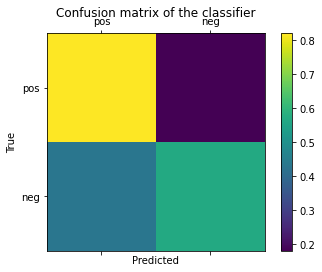


Test Metrics
Accuracy Score: 0.756
PR AUC Score: 0.548



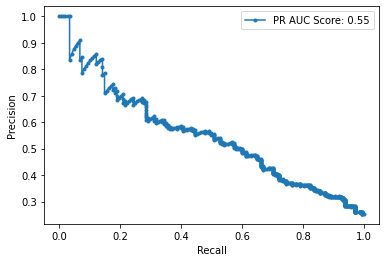

In [ ]:


cm = confusion_matrix(test_true_labels, test_predictions_labels,
                      normalize = 'true')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + ['pos', 'neg'])
ax.set_yticklabels([''] + ['pos', 'neg'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

test_prec, test_rec, _ = precision_recall_curve(test_true_labels, test_pos_probs)
test_pr_auc = auc(test_rec, test_prec)

test_acc = accuracy_score(test_true_labels, test_predictions_labels)
print('')
print('Test Metrics')
print('Accuracy Score: {:.3f}'.format(test_acc))
print('PR AUC Score: {:.3f}'.format(test_pr_auc))
print('')

# plot the no skill precision-recall curve
#pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

from matplotlib import pyplot
# plot the model precision-recall curve
pyplot.plot(test_rec, test_prec, marker='.', label='PR AUC Score: {:.2f}'.format(test_pr_auc))
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
test_rec

array([1.        , 0.99324324, 0.99324324, 0.99324324, 0.99324324,
       0.99324324, 0.99324324, 0.99324324, 0.99324324, 0.99324324,
       0.99324324, 0.99324324, 0.99324324, 0.99324324, 0.99324324,
       0.99324324, 0.99324324, 0.98648649, 0.98648649, 0.98648649,
       0.98648649, 0.98648649, 0.98648649, 0.98648649, 0.97972973,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.97297297, 0.97297297, 0.97297297,
       0.97297297, 0.97297297, 0.96621622, 0.96621622, 0.96621